# Ray Tracing with Dijkstra

Welcome to the notebook on ray tracing based on Dijkstra's algorithm!

## What is Ray Tracing?

"One problem with discussing ray-tracing is that ray-tracing is an overloaded term [[1](https://www.scratchapixel.com/lessons/3d-basic-rendering/ray-tracing-overview/ray-tracing-rendering-technique-overview)]."

In 3D computer graphics (CG), ray tracing is a **rendering technique** for generating an image by tracing the path of light as pixels in an image plane and simulating the effects of its encounters with virtual objects [[2](https://en.wikipedia.org/wiki/Ray_tracing_(physics))]. It is the technique that studios like Disney and Pixar use to create their animated 3D films. In physics, ray tracing is a **method for calculating the path of waves or particles** through a system with regions of varying propagation velocity, absorption characteristics, and reflecting surfaces [[3](https://en.wikipedia.org/wiki/Ray_tracing_(graphics)].

While these two definitions are highly similar (we essentially trace a path of light from a source to a sink), an important distinction lies on how the source is defined (Fig. 1). Ray-tracing in physics is the more intuitive way: we start at a light source and follow the path of each ray, a process called forward tracing. This process is not very useful for computer graphics, as most of the rays will not hit the observer and many computations will not be used. Therefore, modern rendering techniques rely on reverse tracing, where we define the observer as the source, and we only follow the rays that reaches the light source.

![](https://raysect.github.io/documentation/_images/ray-tracing_directions.png)

**Fig. 1** Ray-tracing can be done in both the forward and reverse directions. Ray-tracing is naturally recursive. (Carr, M., Meakins, A., et. al. (2017)) [[4](https://raysect.github.io/documentation/how_it_works.html#id1)]

In this notebook, we will only concern ourselves with the forward tracing algorithm in the 2D space (so no fancy rendered images, unfortunately). Those who are interested in the reverse tracing algorithm can also follow these tutorials in Python [[5](https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9)] (beginner) and in Julia [[6](https://www.youtube.com/watch?v=MkkZb5V6HqM),[7](https://computationalthinking.mit.edu/Fall20/hw7/)] (intermediate).

## Dijkstra's Algorithm

Dijkstra's algorithm (DA) is an algorithm for finding the shortest paths between nodes in a graph.

In [1]:
using Plots, PlutoUI, LinearAlgebra, STMO, DataStructures

In [2]:
struct Pixel
    x::Int
    y::Int
end

In [3]:
function GetAdjacencyList(w, h, circle, circle_ior)
    pixel_nodes = Dict()
    for i = 1:h
        for j=1:w
            pixel_nodes[Pixel(i, j)] = []
            ρ = (i,j) ∈ circle ? circle_ior : 1

            if j < w
                push!(pixel_nodes[Pixel(i,j)], (ρ, Pixel(i, j+1)))
                # Diagonals
                i < h && push!(pixel_nodes[Pixel(i,j)], (ρ*sqrt(2), Pixel(i+1, j+1)))
                i > 1 && push!(pixel_nodes[Pixel(i,j)], (ρ*sqrt(2), Pixel(i-1, j+1)))
            end

            if j > 1
                push!(pixel_nodes[Pixel(i,j)], (ρ, Pixel(i, j-1)))
                # Diagonals
                i < h && push!(pixel_nodes[Pixel(i,j)], (ρ*sqrt(2), Pixel(i+1, j-1)))
                i > 1 && push!(pixel_nodes[Pixel(i,j)], (ρ*sqrt(2), Pixel(i-1, j-1)))
            end

            # Left and right
            i < h && push!(pixel_nodes[Pixel(i,j)], (ρ, Pixel(i+1, j)))
            i > 1 && push!(pixel_nodes[Pixel(i,j)], (ρ, Pixel(i-1, j)))
        end
    end
    return pixel_nodes
end

GetAdjacencyList (generic function with 1 method)

In [4]:
function GetCircleEdgePoints(r, x_center=0, y_center=0)
    points = []
    x = r 
    y = 0
    # Printing the initial point the  
    # axes after translation
    push!(points, (x+x_center, y+y_center))
      
    # When radius is zero only a single point will be returned
    if r > 0
        push!(points, (-x+x_center, y_center), (x_center, r+y_center),
            (x_center, -r+y_center))
    end
    
    # Initializing the value of P  
    P = 1 - r  
  
    while x > y
      
        y += 1
          
        # Mid-point inside or on the perimeter 
        if P <= 0
            P += 2y + 1
              
        # Mid-point outside the perimeter  
        else       
            x -= 1
            P += 2y-2x+1
        end
        
        # All the perimeter points have already been added  
        x < y && break
          
        # Adding the reflection of the generated point in the other octants
        push!(points, (x+x_center, y+y_center), (-x+x_center, y+y_center),
            (x+x_center, -y+y_center), (-x+x_center, -y+y_center))

        # If the generated point is on the line x = y then  
        # the perimeter points have already been added
        if x != y
            push!(points, (y+x_center, x+y_center), (-y+x_center, x+y_center),
                (y+x_center, -x+y_center), (-y+x_center, -x+y_center))
        end
    end
    return points
end

GetCircleInsidePoints(r, x_center=0, y_center=0) = 
    [(x,y) for x=-r+x_center:r+x_center, y=-r+y_center:r+y_center
        if (x-x_center)^2 + (y-y_center)^2 < r^2]

GetCircleInsidePoints (generic function with 3 methods)

In [5]:
"""
    dijkstra(graph::AdjList{R,T}, source::T, sink::T) where {R<:Real,T}

Dijkstra's shortest path algorithm.

Inputs:
    - `graph` : adjacency list representing a weighted directed graph
    - `source`
    - `sink`

Outputs:
    - the shortest path
    - the cost of this shortest path
"""
function dijkstra(graph, source, sink)
    # initialize the tentative distances
    distances = Dict(v => Inf for v in keys(graph))
    distances[source] = 0
    previous = Dict()
    pq = PriorityQueue()
    enqueue!(pq, source, 0)
    while length(pq) > 0
        u = dequeue!(pq)
        u == sink && break
        
        for (dist_to_v, v) in graph[u]
            alternative = distances[u] + dist_to_v
            if alternative < distances[v]
                distances[v] = alternative
                previous[v] = u
                pq[v] = alternative
            end
        end
    end
    return distances, previous
end


dijkstra

In [6]:
"""
    reconstruct_path(previous::Dict{T,T}, source::T, sink::T) where {T}

Reconstruct the path from the output of the Dijkstra algorithm.

Inputs:
        - previous : a Dict with the previous node in the path
        - source : the source node
        - sink : the sink node
Ouput:
        - the shortest path from source to sink
"""
function reconstruct_path(previous, source, sink)
    if source ∉ values(previous)
        return []
    end
    v = sink
    path = [v]
    while v != source
       v = previous[v] 
        pushfirst!(path, v)
    end
    return path
end

reconstruct_path

In [19]:
function plot_paths(p::Plots.Plot, paths)
    for path in paths
        for (i, pixel) in enumerate(path[1:end-1])
            plot!(p, [pixel.x, path[i+1].x], [pixel.y, path[i+1].y],
                label=false, color=:red, lw=3)
        end
    end
end

function plot_pixel_edges(p::Plots.Plot, adj_list)
    for (pixel, pixel_list) in adj_list
        for pix in last.(pixel_list)
                plot!(p, [pixel.x, pix.x], [pixel.y, pix.y],
                label=false, color=:black)
        end
    end   
end

function plot_pixels(p::Plots.Plot, adj_list)
    pixels = [(pixel.x, pixel.y) for pixel in keys(pixel_nodes)]
    plot!(p, first.(pixels), last.(pixels), seriestype = :scatter,
        markersize = 50/maximum(first.(pixels)))
end

function plot_circle(p::Plots.Plot, r, x_center=0, y_center=0, plot_pixels=true)
    if plot_pixels
        points = GetCircleEdgePoints(r, x_center, y_center)
        points_inside = GetCircleInsidePoints(r, x_center, y_center)
        plot!(p, first.(points), last.(points), seriestype = :scatter,
         markerstrokewidth=0, color=:blue)
        plot!(p, first.(points_inside), last.(points_inside),
            seriestype = :scatter, markerstrokewidth=0, color=:gray)
    else
        θ = LinRange(0, 2π, 500)
        x = x_center .+ r*sin.(θ)
        y = y_center .+ r*cos.(θ)
        plot!(p, x, y, seriestype=[:shape], legend=false, fillalpha=0.5)
    end
    p
end

plot_circle (generic function with 4 methods)

In [8]:
# Define circle
r, x_center, y_center = 20, 45, 30
test_circle = union(Set(GetCircleEdgePoints(r, x_center, y_center)),
                    Set(GetCircleInsidePoints(r, x_center, y_center)));

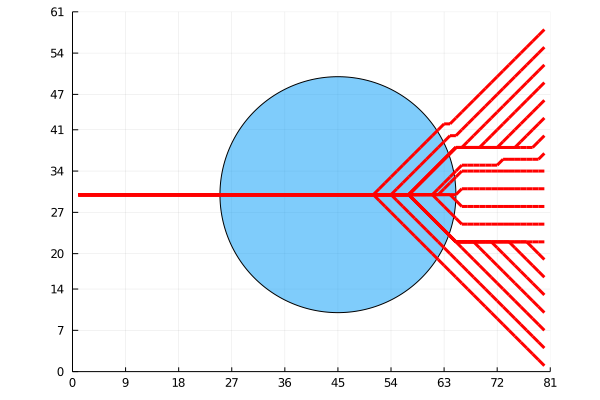

In [20]:
pixel_nodes = GetAdjacencyList(60, 80, test_circle, 0.75);
pixels = [(pixel.x, pixel.y) for pixel in keys(pixel_nodes)]
w, h = maximum(first.(pixels)), maximum(last.(pixels))
p = plot(xticks = round.(LinRange(0, w+1, 10)), xlims = (0,w+1),
        yticks=round.(LinRange(0, h+1, 10)), ylims=(0,h+1), legend=false,
        aspectratio=1)

sources = [Pixel(1,30) for k=1:3:60]
sinks = [Pixel(80,k) for k=1:3:60]
path = [reconstruct_path(dijkstra(pixel_nodes, sources[i], sinks[i])[2], sources[i], sinks[i])
    for i=1:length(sources)];

plot_circle(p, r, x_center, y_center, false)
plot_paths(p, path)
plot(p)

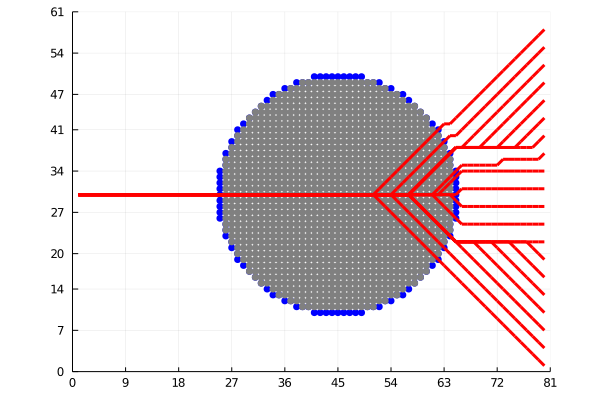

In [22]:
pixel_nodes = GetAdjacencyList(60, 80, test_circle, 0.75);
pixels = [(pixel.x, pixel.y) for pixel in keys(pixel_nodes)]
w, h = maximum(first.(pixels)), maximum(last.(pixels))
p = plot(xticks = round.(LinRange(0, w+1, 10)), xlims = (0,w+1),
        yticks=round.(LinRange(0, h+1, 10)), ylims=(0,h+1), legend=false,
        aspectratio=1)

sources = [Pixel(1,30) for k=1:3:60]
sinks = [Pixel(80,k) for k=1:3:60]
path = [reconstruct_path(dijkstra(pixel_nodes, sources[i], sinks[i])[2], sources[i], sinks[i])
    for i=1:length(sources)];

plot_circle(p, r, x_center, y_center)
plot_paths(p, path)
plot(p)

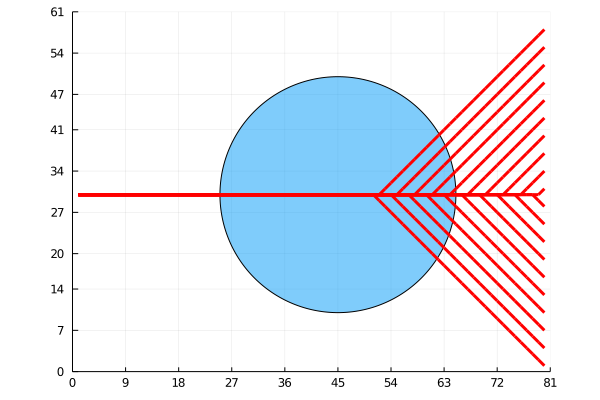

In [21]:
pixel_nodes = GetAdjacencyList(60, 80, test_circle, 1);
pixels = [(pixel.x, pixel.y) for pixel in keys(pixel_nodes)]
w, h = maximum(first.(pixels)), maximum(last.(pixels))
p = plot(xticks = round.(LinRange(0, w+1, 10)), xlims = (0,w+1),
        yticks=round.(LinRange(0, h+1, 10)), ylims=(0,h+1), legend=false,
        aspectratio=1)

sources = [Pixel(1,30) for k=1:3:60]
sinks = [Pixel(80,k) for k=1:3:60]
path = [reconstruct_path(dijkstra(pixel_nodes, sources[i], sinks[i])[2], sources[i], sinks[i])
    for i=1:length(sources)];

plot_circle(p, r, x_center, y_center, false)
plot_paths(p, path)
plot(p)

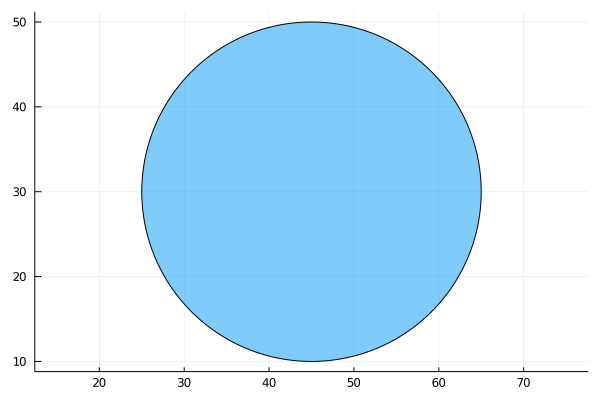

In [15]:
p = plot()
plot_circle(p, r, x_center, y_center, false)